# Spark RDDs, DataFrames and Spark SQL

<img src="https://upload.wikimedia.org/wikipedia/commons/e/ea/Spark-logo-192x100px.png" width="25%" height="25%">

This notebook uses Spark RDDs and DataFrames with Spark SQL to explore 2014 NFL regular season player game statistics.


<img src="http://cdn.idigitaltimes.com/sites/idigitaltimes.com/files/2015/10/20/nfl-oculus.jpg" width="25%" height="25%">


## Uploading the Data File
The NFL 2014 regular season player statistics data file was uploaded into this notebook by going to the **Data Source** panel of the **Palette** and using the **Add** button and choosing the option **From file** to upload the CSV file. The uploaded file appears in the **Data Source** panel on the **Palette** and is saved in Object Storage.


<img src="https://cdsax.cloudant.com/public-samples/notebookswithspark/2015_data_source.png" width="25%" height="25%"> 



## Load Data
Before the data file stored in Object Storage can be accessed using the `SparkContext`, the Hadoop configuration must be set.

##Define a credentials dictionary that can be used whenwe access the csv file stored in Object Storage.


In [18]:
## Credential Dictionary 
credentials = {}
credentials['name'] = 'gbrunell'
credentials['auth_url'] = 'https://identity.open.softlayer.com'
credentials['container'] = 'notebooks'
credentials['filename'] = 'SportsData_NFL_2014_REG_PST_players.csv'
credentials['project_id'] = '862d39daeb804ed5a24898160c008b96'
credentials['region'] = 'dallas'
credentials['user_id'] = '97969c8b5b0c4eb8a8a7bcca7f4d12c1'
credentials['password'] = 'b4{eAKb7N{4pDx9='

Now set the configuration using this credentials dictionary.

In [22]:
## Hadoop Credentials 
def set_hadoop_config(credentials):
    prefix = 'fs.swift.service.' + credentials['name'] 
    hconf = sc._jsc.hadoopConfiguration()
    hconf.set(prefix + '.auth.url', credentials['auth_url']+'/v3/auth/tokens')
    hconf.set(prefix + '.auth.endpoint.prefix', "endpoints")
    hconf.set(prefix + '.tenant', credentials['project_id'])
    hconf.set(prefix + '.username', credentials['user_id'])
    hconf.set(prefix + '.password', credentials['password'])
    hconf.setInt(prefix + '.http.port', 8080)
    hconf.set(prefix + '.region', credentials['region'])
    hconf.setBoolean(prefix + '.public', True)

##Set and Use Credentials to access the CSV File

In [23]:
set_hadoop_config(credentials)


In [24]:
NFLdata = sc.textFile("swift://" + credentials['container'] +"." + credentials['name'] + '/' + credentials['filename']) 
##    behind hte scenes NFLdata = sc.textFile("swift://notebooks.keystone/SportsData_NFL_2014_REG_PST_players.csv")
NFLdata.take(2)

[u'Week,Game ID,Field Type,Stadium Type,Weather Temperature,Weather Condition,Weather Wind Speed,Team,Opponent,Location,Player Name,Position,Rushing Attempts,Rushing Yards,Rushing TD,Receiving Targets,Receptions,Receiving Yards,Receiving TD,Total TD,Fumbles,Pass Attempts,Pass Completions,Passing Yards,Passing TD,Interceptions',
 u'1,1,artificial,outdoor,73,Sunny,11,Seahawks,GB,Home,Byron Maxwell,CB,0,0,0,0,0,0,0,0,0,0,0,0,0,0']

In [28]:
set_hadoop_config(credentials)


##We can now access he data file stored in Object Storage using the configured `SparkContext` in our notebook. 

Let's create an `RDD` from the raw data file. We will refer to it using a URI of the form: 

```




In [26]:
NFLdata = sc.textFile("swift://" + credentials['container'] +"." + credentials['name'] + '/' + credentials['filename']) 
NFLdata.take(2)


[u'Week,Game ID,Field Type,Stadium Type,Weather Temperature,Weather Condition,Weather Wind Speed,Team,Opponent,Location,Player Name,Position,Rushing Attempts,Rushing Yards,Rushing TD,Receiving Targets,Receptions,Receiving Yards,Receiving TD,Total TD,Fumbles,Pass Attempts,Pass Completions,Passing Yards,Passing TD,Interceptions',
 u'1,1,artificial,outdoor,73,Sunny,11,Seahawks,GB,Home,Byron Maxwell,CB,0,0,0,0,0,0,0,0,0,0,0,0,0,0']

The `RDD` we created is a collection of strings corresponding to the individual lines in the raw CSV data file. It is also important to remember that the `RDD` is defined but not instantiated yet. We can apply an action like `count` to the `RDD` which will effectively force its instantiation.

also be sure you understand the difference between local storge and object sotrage

In [8]:
!pwd

/gpfs/fs01/user/s64f-cd88bf3504b094-0e064d06fabc/notebook/notebooks



In [9]:
!ls

Intro.png		    derby.log		   win_loss.png
Intro.png.1		    football_scores.csv    world_bank.json.gz
Intro.png.2		    football_scores.csv.1  world_bank.json.gz.1
OnlineRetail.csv.gz	    football_scores.csv.2  world_bank.json.gz.2
TrapezoidRule.ipynb	    metastore_db	   world_bank.json.gz.3
WeatherPrecipitation.ipynb  nfl_weather.csv
anothertry.png		    nfl_weather.csv.1


In [25]:
print "Total records in the SportsData_NFL_2014_REG_PST_players dataset:", NFLdata.count()
# This is an action.

Total records in the SportsData_NFL_2014_REG_PST_players dataset: 37864


Spark can cache datasets in memory to speed up reuse. Let's cache the `NFLdata` RDD.

In [31]:
NFLdata.cache()

MapPartitionsRDD[13] at textFile at NativeMethodAccessorImpl.java:-2

We can apply another action `first`, to the same `RDD` to take a look at the first row of the data.

In [32]:
print "The first row in the SportsData_NFL_2014_REG_PST_players2015.csv dataset:", NFLdata.first()
# Another action, which this time is processed faster as the data is cached.

The first row in the SportsData_NFL_2014_REG_PST_players2015.csv dataset: Week,Game ID,Field Type,Stadium Type,Weather Temperature,Weather Condition,Weather Wind Speed,Team,Opponent,Location,Player Name,Position,Rushing Attempts,Rushing Yards,Rushing TD,Receiving Targets,Receptions,Receiving Yards,Receiving TD,Total TD,Fumbles,Pass Attempts,Pass Completions,Passing Yards,Passing TD,Interceptions


## Parsing the Data
<img src="http://www.picturesof.net/_images_300/A_Shredder_Shredding_Paper_Royalty_Free_Clipart_Picture_081211-150312-640018.jpg" width="10%" height="10%">

To really begin working with the data, we need to parse it into columns. We can accomplish this by mapping each line in the `RDD` to a function that splits the line by commas.

The lambda notation in Python is used to create anonymous functions (i.e functions which are not bound to a name). This concept is used for passing a function as a parameter to the map function. The anonymous function receives each line from the RDD "NFLdata" and splits it at the comma boundaries.

In [33]:
NFLdataParse = NFLdata.map(lambda line : line.split(","))
# Just a transformation

As a result, the new RDD "NFLdataParse" is defined as a list of lists of strings. Each list in "NFLdataParse" corresponds to a line in "NFLdata" and the strings in each list are the individual elements of the row.

In [34]:
NFLdataParse.first()
# An action

[u'Week',
 u'Game ID',
 u'Field Type',
 u'Stadium Type',
 u'Weather Temperature',
 u'Weather Condition',
 u'Weather Wind Speed',
 u'Team',
 u'Opponent',
 u'Location',
 u'Player Name',
 u'Position',
 u'Rushing Attempts',
 u'Rushing Yards',
 u'Rushing TD',
 u'Receiving Targets',
 u'Receptions',
 u'Receiving Yards',
 u'Receiving TD',
 u'Total TD',
 u'Fumbles',
 u'Pass Attempts',
 u'Pass Completions',
 u'Passing Yards',
 u'Passing TD',
 u'Interceptions']

Let us now take a look at individual elements of this first list where the first entry starts at offset zero.

In [39]:
NFLdataParse.first()[7]

u'Team'

We can also pull other elements by index.

In [ ]:
NFLdataParse.first()[17]

## Exploring the Data
<img src="http://www.wpclipart.com/people/professions/police/detective_with_pipe_and_magnifying_glass.png" width="5%" height="5%">
### Select only wide receivers

Let's now reduce the dataset by selecting only players who play wide receiver. That is, those rows where the "Position" column equals "WR".

In [40]:
NFLdataWR = NFLdataParse.filter(lambda x: x[11] == "WR")
# x[11} is the player's Position
NFLdataWR.first()

[u'1',
 u'1',
 u'artificial',
 u'outdoor',
 u'73',
 u'Sunny',
 u'11',
 u'Seahawks',
 u'GB',
 u'Home',
 u'Jermaine Kearse',
 u'WR',
 u'0',
 u'0',
 u'0',
 u'3',
 u'1',
 u'8',
 u'0',
 u'0',
 u'0',
 u'0',
 u'0',
 u'0',
 u'0',
 u'0']

###  Calculate Average WR Receiving Yards per Game by Team

Let's calculate the average receiving yards by wide receivers per game by team.

The RDD `NFLdataWR` contains embedded within it a list of pairs (v1, v2), where v1 is the player's Team and v2 the Receiving Yards for a given game for a WR on that team.

<table border="1" style="width:80%">
  <tr>
    <th>Key</th><th>Value</th>
  </tr>
  <tr>
    <td>Team 1</td><td>Receiving Yards for Player 1</td>
  </tr>
  <tr>
    <td>Team 2</td><td>Receiving Yards for Player 2</td>
  </tr>
  <tr>
    <td>Team 1</td><td>Receiving Yards for Player 3</td>
  </tr>
    <tr>
    <td>Team 2</td><td>Receiving Yards for Player 4</td>
  </tr>
    <tr>
    <td>Team 3</td><td>Receiving Yards for Player 5</td>
  </tr>
  <tr>
    <td>...</td><td>...</td>
  </tr>
</table>
<p>

Create RDD pair (v1,v2) as described above.

In [41]:
# x[7] is the Team
# x[17] is the Receiving Yards
NFLdataWRpair = NFLdataWR.map(lambda x : (x[7], (int(x[17]))))
NFLdataWRpair.takeSample(0, 5, 87) # Return 5 key/value pairs at random - 87 is just a random number seed

[(u'Redskins', 95),
 (u'Bears', 112),
 (u'Jets', 129),
 (u'Jaguars', 0),
 (u'Rams', 20)]

Our next goal is to transform (map) this dataset into a new one where each row (data pair) is augmented with the value `1`. This will enable us to compute the average recieving yards per WR for each team by dividing the sum of receiving yards by the corresponding count, which represents the number of records in the data.

<table border="1" style="width:80%">
  <tr>
    <th>Key</th><th>Value</th>
  </tr>
  <tr>
    <td>Team 1</td><td>(Receiving Yards for Player 1,1)</td>
  </tr>
  <tr>
    <td>Team 2</td><td>(Receiving Yards for Player 2,1)</td>
  </tr>
    <tr>
    <td>Team 1</td><td>(Receiving Yards for Player 3,1)</td>
  </tr>
    <tr>
    <td>Team 2</td><td>(Receiving Yards for Player 4,1)</td>
  </tr>
    <tr>
    <td>Team 3</td><td>(Receiving Yards for Player 5,1)</td>
  </tr>
  <tr>
    <td>...</td><td>...</td>
  </tr>
</table>
<p>



Create "playersWRCountByKey", which will have the structure just described.

In [42]:
# x[7] is the Team
# x[17] is the Receiving Yards
NFLdataWRCountByKey = NFLdataWR.map(lambda x : (x[7], (int(x[17]), 1)))
# Note that the map function is operating on the RDD `NFLdataWR` not the RDD `NFLdataWRpair` that was created in the last step.
# The last step was merely for illustrative purposes.

We can again look at the first element of our new `RDD` to confirm that our mapping produced the expected result.

In [43]:
NFLdataWRCountByKey.first()
# Remember that this is just a value pair that represents the recieving yards for a single wide receiver for a single game.

(u'Seahawks', (8, 1))

We can validate that the key is the team name.

In [44]:
NFLdataWRCountByKey.keys().first()

u'Seahawks'

Let's also confirm the associated value is (RecievingYards, 1).

In [45]:
NFLdataWRCountByKey.values().first()

(8, 1)

The reason for this mapping is to subsequently be able to reduce the table into the following form.

<table border="1" style="width:80%">
  <tr>
    <th>Key</th><th>Value</th>
  </tr>
  <tr>
    <td>Team 1</td><td>(Receiving Yards for Player 1 + Receiving Yards for Player 3,2)</td>
  </tr>
  <tr>
    <td>Team 2</td><td>(Receiving Yards for Player 2 + Receiving Yards for Player 4,2)</td>
  </tr>
    <tr>
    <td>Team 3</td><td>(Receiving Yards for Player 5,1)</td>
  </tr>
  <tr>
    <td>...</td><td>...</td>
  </tr>
</table>
<p>

Now we can sum (reduce) the Receiving Yard amounts and total number of WRs for every Team. We use `reduceByKey` for this purpose.

In [46]:
NFLdataWRAddByKey = NFLdataWRCountByKey.reduceByKey(lambda v1,v2 : (v1[0]+v2[0], v1[1]+v2[1]))

Let's inspect the Total Receiving Yards and total number of WRs who played in games for 5 of the teams.

In [47]:
NFLdataWRAddByKey.top(5)

[(u'Vikings', (2326, 116)),
 (u'Titans', (2020, 124)),
 (u'Texans', (2585, 120)),
 (u'Steelers', (3470, 135)),
 (u'Seahawks', (2480, 152))]

Now we can finally compute the average wide receiving yards per team. We create the `NFLdataWRAverage` RDD by mapping the `NFLdataWRAddByKey` RDD through a function that divides the total receiving yards by the total number of data points (wide recievers who played in a game).

In [48]:
NFLdataWRAverage = NFLdataWRAddByKey.map(lambda k: (k[0], k[1][0] / float(k[1][1] ) ) )

### Average WR Receiving Yards per game of 10 teams
<img src="https://encrypted-tbn2.gstatic.com/images?q=tbn:ANd9GcT6l18mILYcHa6p3yUqx5IHE8-M25piqALPHPYIKZTB7yZpCpqn" width="15%" height="15%">

In [49]:
NFLdataWRAverage.top(10)

[(u'Vikings', 20.051724137931036),
 (u'Titans', 16.29032258064516),
 (u'Texans', 21.541666666666668),
 (u'Steelers', 25.703703703703702),
 (u'Seahawks', 16.31578947368421),
 (u'Saints', 17.959183673469386),
 (u'Redskins', 19.223776223776223),
 (u'Ravens', 16.29078014184397),
 (u'Rams', 17.308333333333334),
 (u'Raiders', 17.04724409448819)]

Let's format the results.

In [50]:
for pair in NFLdataWRAverage.top(10):
    print "%s had average WR receiving yards per game of %f in 2014." % (pair[0],pair[1])

Vikings had average WR receiving yards per game of 20.051724 in 2014.
Titans had average WR receiving yards per game of 16.290323 in 2014.
Texans had average WR receiving yards per game of 21.541667 in 2014.
Steelers had average WR receiving yards per game of 25.703704 in 2014.
Seahawks had average WR receiving yards per game of 16.315789 in 2014.
Saints had average WR receiving yards per game of 17.959184 in 2014.
Redskins had average WR receiving yards per game of 19.223776 in 2014.
Ravens had average WR receiving yards per game of 16.290780 in 2014.
Rams had average WR receiving yards per game of 17.308333 in 2014.
Raiders had average WR receiving yards per game of 17.047244 in 2014.


The `Team` name dictates the sort order of the `top` call because it appears first in the (Team, average WR receiving yards) tuple.

### Descending order of Teams by Average WR Receiving Yards per game

If we want to output the 10 teams with the highest average receiving yards per catch, we must flip-flop the `Team` and average `ReceivingYards` pair order. We can do this simply with a `map` function that swaps the pair order.

In [51]:
NFLdataWRAverageTop10=[]
TeamTop10=[]
for pair in NFLdataWRAverage.map(lambda (x,y) : (y,x)).top(10):
    NFLdataWRAverageTop10.append(pair[0])
    TeamTop10.append(pair[1])
    print "%s had average receiving yards per game of %f in 2014" % (pair[1],pair[0])

Falcons had average receiving yards per game of 26.717391 in 2014
Steelers had average receiving yards per game of 25.703704 in 2014
Lions had average receiving yards per game of 24.300000 in 2014
Cowboys had average receiving yards per game of 24.076923 in 2014
Buccaneers had average receiving yards per game of 23.953704 in 2014
Packers had average receiving yards per game of 23.806452 in 2014
Broncos had average receiving yards per game of 23.452229 in 2014
Chargers had average receiving yards per game of 23.185841 in 2014
Cardinals had average receiving yards per game of 22.893443 in 2014
Dolphins had average receiving yards per game of 22.660714 in 2014


Now let's plot the results.

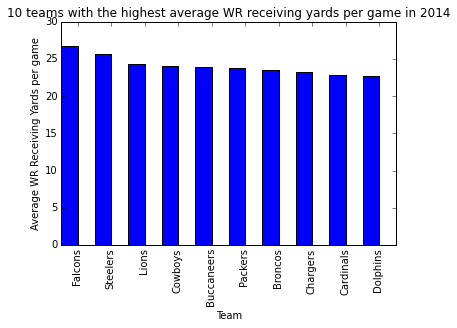

In [52]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

N = 10
index = np.arange(N)  
bar_width = 0.5

plt.bar(index, NFLdataWRAverageTop10, bar_width,
                 color='b')
plt.xlabel('Team')
plt.ylabel('Average WR Receiving Yards per game')
plt.title('10 teams with the highest average WR receiving yards per game in 2014')
plt.xticks(index + bar_width, TeamTop10, rotation=90)
plt.show()

## Use Spark Data Frames to analyze the data
<img src="https://databricks.com/wp-content/uploads/2015/02/Introducing-DataFrames-in-Spark-for-Large-Scale-Data-Science1.png" width="50%" height="50%">

To create a data frame of 2014 NFL regular season player statistics by game, we will use the `SQLContext` and `Row` class from the `pyspark.sql` module. Each of the lines from the `NFLdataWR` RDD will be used to create a row object. Each of the row's attributes will be used to access the value of each column -  just like you would do to a relational table.

In [62]:
# Import the SQLContext and Row class from the pyspark.sql module
from pyspark.sql import SQLContext, Row
# instantiate SQLContext object
sqlContext = SQLContext(sc)

First we convert each line of the `NFLdataWR` RDD into a row object while infering and applying a schema to the RDD.

In [63]:
# Convert each line of NFLdataWR RDD into a Row object and apply a Row Schema
NFLdataWRRows= NFLdataWR.map(lambda p: Row(PlayerName=p[10], Team=p[7], ReceivingYards=int(p[17])))


Next we convert the RDD to a Data Frame.

In [64]:
# Convert the RDD to a Data Frame
NFLdataWRDataFrame = sqlContext.createDataFrame(NFLdataWRRows)

Let's preview the Data Frame schema.

In [65]:
NFLdataWRDataFrame.printSchema()

root
 |-- PlayerName: string (nullable = true)
 |-- ReceivingYards: long (nullable = true)
 |-- Team: string (nullable = true)



Now let's look at some of the Data Frame data filtering on WR who had 200 yard receiving games.

In [66]:
NFLdataWRDataFrame.select('PlayerName', 'Team', 'ReceivingYards').where(NFLdataWRDataFrame['ReceivingYards'] > 200).show()

+----------------+----------+--------------+
|      PlayerName|      Team|ReceivingYards|
+----------------+----------+--------------+
|    Jordy Nelson|   Packers|           209|
|Demaryius Thomas|   Broncos|           226|
|     T.Y. Hilton|     Colts|           223|
|      Mike Evans|Buccaneers|           209|
| DeAndre Hopkins|    Texans|           238|
|      A.J. Green|   Bengals|           224|
|     Julio Jones|   Falcons|           259|
|     Eric Decker|      Jets|           221|
+----------------+----------+--------------+



### Descending order of Teams by average WR Receiving Yards with DataFrames
Let's report the average WR Receiving Yards per game by Team as we did above, but this time using Data Frames.

In [67]:
NFLdataWRDataFrame \
.groupby(['Team'])\
.agg({"ReceivingYards": "avg"})\
.sort("avg(ReceivingYards)", ascending=False)\
.show(10)

+----------+-------------------+
|      Team|avg(ReceivingYards)|
+----------+-------------------+
|   Falcons| 26.717391304347824|
|  Steelers| 25.703703703703702|
|     Lions|               24.3|
|   Cowboys| 24.076923076923077|
|Buccaneers| 23.953703703703702|
|   Packers| 23.806451612903224|
|   Broncos| 23.452229299363058|
|  Chargers|   23.1858407079646|
| Cardinals|  22.89344262295082|
|  Dolphins| 22.660714285714285|
+----------+-------------------+
only showing top 10 rows



## Use Spark SQL to analyze the data
<img src="https://media.licdn.com/mpr/mpr/jc/AAEAAQAAAAAAAASuAAAAJDk3NGUwNWJkLWJkZGEtNGQzMy05OTJmLTIwZDc3OWU2MzZlYw.jpg" width="25%" height="25%">


A Spark DataFrame can also be registered as a temporary table in Spark SQL. Registering a DataFrame as a table allows you to run SQL queries over its data. The `sql` function enables applications to run SQL queries programmatically and returns the result as a DataFrame.

Register a table called 'NFLdataWRTable' with 3 columns: PlayerName, Team and ReceivingYards

In [68]:
NFLdataWRDataFrame.registerTempTable("NFLdataWRTable")

Spark SQL can cache tables using an in-memory columnar format.

In [69]:
sqlContext.cacheTable("NFLdataWRTable")

### Descending order of Teams by average WR Receiving Yards
Let's report the average WR Receiving Yards per game by Team as we did above, but this time using Spark SQL. Spark SQL` provides a SQL-like interface. It also can be a very powerful tool for performing complex aggregations.

In [70]:
NFLdataWRAverageSQL = sqlContext.sql("SELECT Team, AVG(ReceivingYards) as TotalReceivingYards FROM NFLdataWRTable GROUP BY Team ORDER BY TotalReceivingYards DESC LIMIT 10")
NFLdataWRAverageSQL.show()

+----------+-------------------+
|      Team|TotalReceivingYards|
+----------+-------------------+
|   Falcons| 26.717391304347824|
|  Steelers| 25.703703703703702|
|     Lions|               24.3|
|   Cowboys| 24.076923076923077|
|Buccaneers| 23.953703703703702|
|   Packers| 23.806451612903224|
|   Broncos| 23.452229299363058|
|  Chargers|   23.1858407079646|
| Cardinals|  22.89344262295082|
|  Dolphins| 22.660714285714285|
+----------+-------------------+

